# Market Basket Analysis

### Loading Required Libraries

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import warnings
warnings.filterwarnings("ignore")

## Data Loading and Cleaning

### Reading Input Files

In [2]:
aisles = pd.read_csv('https://raw.githubusercontent.com/yashwanthky/Market_Basket_Analysis/Data_Loading/aisles_perishables_tagged.csv', index_col = 0, error_bad_lines = False).reset_index()
departments = pd.read_csv('instacart_2017_05_01/departments.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
orders = pd.read_csv('instacart_2017_05_01/orders.csv')
orders_products_train = pd.read_csv('instacart_2017_05_01/order_products__prior.csv')  # We train the model using this data of n-1 orders
orders_products_test = pd.read_csv('instacart_2017_05_01/order_products__train.csv')   # We validate the predictions with this data of the nth order

In [3]:
aisles.head()

,aisle_id,aisle,Perishables
0,1,prepared soups salads,1
1,2,specialty cheeses,1
2,3,energy granola bars,0
3,4,instant foods,0
4,5,marinades meat preparation,1


### Data Check
#### (shape, features, unique values and missing values)

In [4]:
print ("Rows     : " ,aisles.shape[0])
print ("Columns  : " ,aisles.shape[1])
print ("\nFeatures : \n" ,aisles.columns.tolist())
print ("\nMissing values :  ", aisles.isnull().sum().values.sum())
print ("\nUnique values :  \n",aisles.nunique())

Rows     :  134
Columns  :  3

Features : 
 ['aisle_id', 'aisle', 'Perishables']

Missing values :   0

Unique values :  
 aisle_id       134
aisle          134
Perishables      2
dtype: int64


In [5]:
print ("Rows     : " ,departments.shape[0])
print ("Columns  : " ,departments.shape[1])
print ("\nFeatures : \n" ,departments.columns.tolist())
print ("\nMissing values :  ", departments.isnull().sum().values.sum())
print ("\nUnique values :  \n",departments.nunique())

Rows     :  21
Columns  :  2

Features : 
 ['department_id', 'department']

Missing values :   0

Unique values :  
 department_id    21
department       21
dtype: int64


In [6]:
print ("Rows     : " ,products.shape[0])
print ("Columns  : " ,products.shape[1])
print ("\nFeatures : \n" ,products.columns.tolist())
print ("\nMissing values :  ",products.isnull().sum().values.sum())
print ("\nUnique values :  \n",products.nunique())

Rows     :  49688
Columns  :  4

Features : 
 ['product_id', 'product_name', 'aisle_id', 'department_id']

Missing values :   0

Unique values :  
 product_id       49688
product_name     49688
aisle_id           134
department_id       21
dtype: int64


In [7]:
print ("Rows     : " ,orders.shape[0])
print ("Columns  : " ,orders.shape[1])
print ("\nFeatures : \n" ,orders.columns.tolist())
print ("\nMissing values :  ", orders.isnull().sum().values.sum())
print ("\nMissing values :  ", orders.isnull().sum().values)
print ("\nUnique values :  \n",orders.nunique())

Rows     :  3421083
Columns  :  7

Features : 
 ['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']

Missing values :   206209

Missing values :   [     0      0      0      0      0      0 206209]

Unique values :  
 order_id                  3421083
user_id                    206209
eval_set                        3
order_number                  100
order_dow                       7
order_hour_of_day              24
days_since_prior_order         31
dtype: int64


There are 206,209 missing values in the column 'days_since_prior_order'. This means that these orders are the first orders for the 206,209 unique customers

In [8]:
# Let us see the order count by unique user id

print(orders.groupby('user_id').agg({'order_id' : ['count']}).min(),
      orders.groupby('user_id').agg({'order_id' : ['count']}).max(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).mean(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).median(),
     orders.groupby('user_id').agg({'order_id' : ['count']}).std())

order_id  count    4
dtype: int64 order_id  count    100
dtype: int64 order_id  count    16.590367
dtype: float64 order_id  count    10.0
dtype: float64 order_id  count    16.654774
dtype: float64


There are around 10 orders for 75% of the customers and the minimum number of orders per user is 4 and the maximum number of orders per user is 100.

In [9]:
print ("Rows     : " ,orders_products_train.shape[0])
print ("Columns  : " ,orders_products_train.shape[1])
print ("\nFeatures : \n" ,orders_products_train.columns.tolist())
print ("\nMissing values :  ", orders_products_train.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_train.nunique())

Rows     :  32434489
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             3214874
product_id             49677
add_to_cart_order        145
reordered                  2
dtype: int64


In [10]:
print ("Rows     : " ,orders_products_test.shape[0])
print ("Columns  : " ,orders_products_test.shape[1])
print ("\nFeatures : \n" ,orders_products_test.columns.tolist())
print ("\nMissing values :  ", orders_products_test.isnull().sum().values.sum())
print ("\nUnique values :  \n",orders_products_test.nunique())

Rows     :  1384617
Columns  :  4

Features : 
 ['order_id', 'product_id', 'add_to_cart_order', 'reordered']

Missing values :   0

Unique values :  
 order_id             131209
product_id            39123
add_to_cart_order        80
reordered                 2
dtype: int64


## Data Merging

In [11]:
merged_data = pd.merge(orders_products_train,orders, on = 'order_id')
merged_data = pd.merge(merged_data,products, on = 'product_id')
merged_data = pd.merge(merged_data,aisles, on = 'aisle_id')
merged_data = pd.merge(merged_data,departments, on = 'department_id')

Replacing the missing values in the column 'days_since_prior_order' with '999'

In [12]:
merged_data['days_since_prior_order'].fillna('999',inplace = True)

In [13]:
print ("Rows     : " ,merged_data.shape[0])
print ("Columns  : " ,merged_data.shape[1])
print ("\nMissing values :  ",list(zip(merged_data.columns.tolist(),list(merged_data.isnull().sum().values))))
print ("\nUnique values :  \n",merged_data.nunique())

Rows     :  32434489
Columns  :  16

Missing values :   [('order_id', 0), ('product_id', 0), ('add_to_cart_order', 0), ('reordered', 0), ('user_id', 0), ('eval_set', 0), ('order_number', 0), ('order_dow', 0), ('order_hour_of_day', 0), ('days_since_prior_order', 0), ('product_name', 0), ('aisle_id', 0), ('department_id', 0), ('aisle', 0), ('Perishables', 0), ('department', 0)]

Unique values :  
 order_id                  3214874
product_id                  49677
add_to_cart_order             145
reordered                       2
user_id                    206209
eval_set                        1
order_number                   99
order_dow                       7
order_hour_of_day              24
days_since_prior_order         32
product_name                49677
aisle_id                      134
department_id                  21
aisle                         134
Perishables                     2
department                     21
dtype: int64


## Data Exploration

#### Count of users by number of orders placed

We will look at the distribution of number of orders placed by each user - 

In [14]:
user_order = merged_data[['user_id','order_id']].drop_duplicates().groupby(['user_id']).agg({'order_id' : ['count']}).reset_index()
user_order.columns = ['user_id','Orders_Count']
user_order = user_order.groupby(['Orders_Count']).agg({'user_id' : ['count']}).reset_index()
user_order.columns = ['Order_Count','Users']

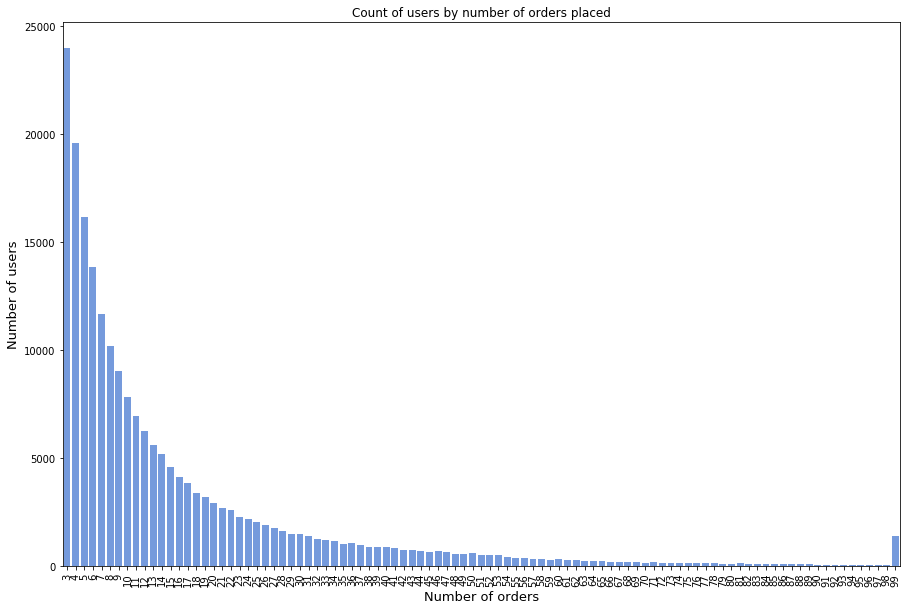

In [15]:
plt.figure(figsize=(15,10))
sns.barplot(x='Order_Count', y='Users',data=user_order, color='cornflowerblue')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Number of orders', fontsize=13)
plt.xticks(rotation='vertical')
plt.title('Count of users by number of orders placed');

We see that it is a right skewed chart with a majority of users having less than 20 orders.

We will now look at how many products users generally buy in one order

#### Count of orders by number of products purchased

In [16]:
order_products = merged_data[['order_id','add_to_cart_order']]
order_products = order_products.groupby(['order_id']).agg({'add_to_cart_order' : ['max']}).reset_index()
order_products.columns = ['order_id','products']
order_products = order_products.groupby(['products']).agg({'order_id' : ['count']}).reset_index()
order_products.columns = ['no_of_products','orders']

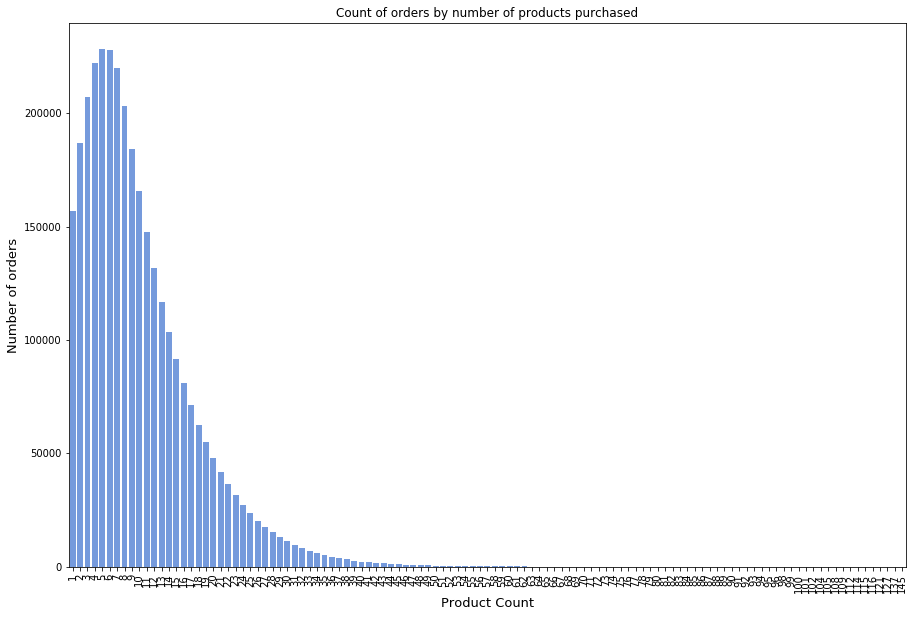

In [17]:
plt.figure(figsize=(15,10))
sns.barplot(x='no_of_products', y='orders',data=order_products, color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Product Count', fontsize=13)
plt.xticks(rotation='vertical')
plt.title('Count of orders by number of products purchased');

The plot follows a right skew distribution and we notice that most of the orders contains upto 10 products in the order

We will look if the orders peak on a particular day of the week

#### Count of Orders by each Day in the Week 

In [18]:
orderperday = merged_data[['order_dow','order_id']].drop_duplicates().groupby('order_dow').agg({'order_id' : ['count']}).reset_index()
orderperday.columns = ['Day_Week','Orders']
orderperday.shape

(7, 2)

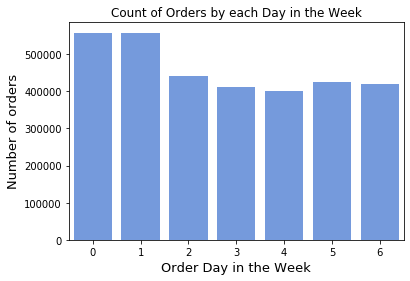

In [19]:
sns.barplot(x='Day_Week', y='Orders',data=orderperday, color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Order Day in the Week', fontsize=13)
plt.title('Count of Orders by each Day in the Week');

We see that most of the orders are placed on day = 0 and day = 1.

#### Count of Orders by Hour in each Day

In [20]:
orderperhour = merged_data[['order_hour_of_day','order_id']].drop_duplicates().groupby('order_hour_of_day').agg({'order_id' : ['count']}).reset_index()
orderperhour.columns = ['Day_hour','Orders']
orderperhour.shape

(24, 2)

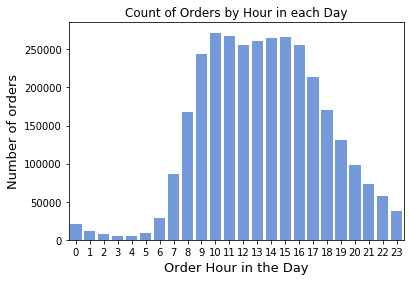

In [21]:
sns.barplot(x='Day_hour', y='Orders',data=orderperhour, color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Order Hour in the Day', fontsize=13)
plt.title('Count of Orders by Hour in each Day');

Most of the ordering activity occurs between 9AM to 4PM before the number of orders placed goes down.

We will now check how often customers place orders on Instacart

#### Distribution showing how frequently users order 

In [22]:
customerorderprior = merged_data[['user_id','order_id','days_since_prior_order']].drop_duplicates()
customerorderprior = customerorderprior.loc[customerorderprior['days_since_prior_order'] != '999']
customerorderprior = customerorderprior.astype('int64', copy = False)
customerorderprior.head()

,user_id,order_id,days_since_prior_order
0,202279,2,8
1,153404,26,7
2,23750,120,10
3,58707,327,8
4,166654,390,9


In [23]:
#customerorderprior.groupby(['user_id'])['days_since_prior_order'].agg(pd.Series.mode).to_frame()
customerorderprior = customerorderprior.groupby('user_id')['days_since_prior_order'].apply(lambda x: x.value_counts().index[0]).reset_index()

In [24]:
customerorderprior.head()
#print ("\nUnique values :  \n",customerorderprior.nunique())

,user_id,days_since_prior_order
0,1,14
1,2,8
2,3,7
3,4,15
4,5,19


In [25]:
customerorderprior = customerorderprior.groupby('days_since_prior_order').agg({'user_id' : ['count']}).reset_index()
customerorderprior.columns = ['days_since_prior_order','users']
customerorderprior.head()

,days_since_prior_order,users
0,0,1029
1,1,3393
2,2,5792
3,3,7931
4,4,7019


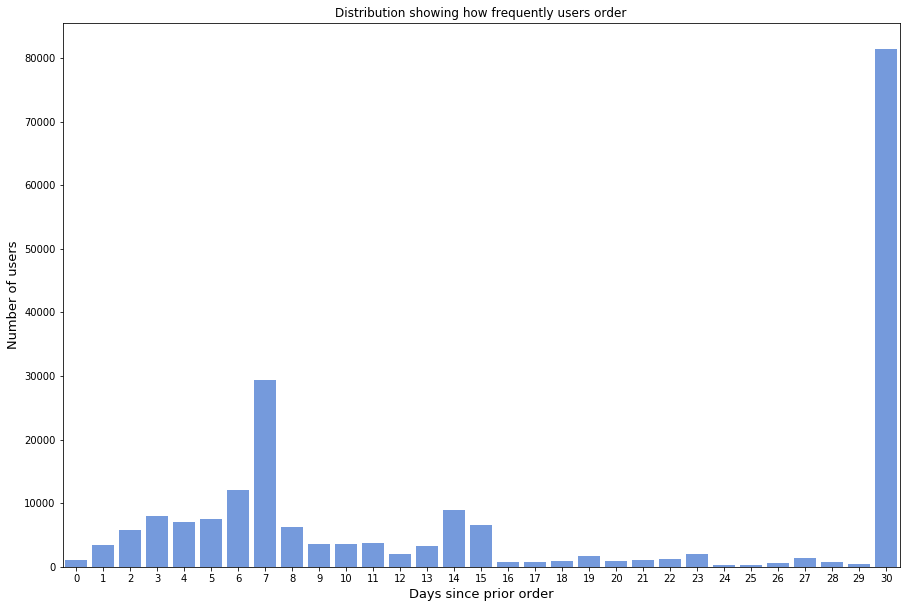

In [26]:
plt.figure(figsize=(15,10))
sns.barplot(x='days_since_prior_order', y='users',data=customerorderprior, color='cornflowerblue')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Days since prior order', fontsize=13)
plt.title('Distribution showing how frequently users order');

The customers who order frequently i.e. every week can be targeted for experimentation with perishable products.

We will go ahead and see what are the products that are driving the orders i.e. the rank of the product in the cart should be 1

#### Top 25 products which are driving orders 

In [27]:
productorderpreference = merged_data[['order_id','product_id','add_to_cart_order']]
productorderpreference = productorderpreference[(productorderpreference.add_to_cart_order == 1)]
productorderpreference = productorderpreference[['order_id','product_id']]
productorderpreference = productorderpreference.groupby('product_id').agg({'order_id' : ['count']}).reset_index()
productorderpreference.columns = ['product_id','orders']
productorderpreference['orderspercent'] = productorderpreference['orders']/productorderpreference['orders'].sum()
productorderpreference = productorderpreference.sort_values(by='orderspercent', ascending=False)

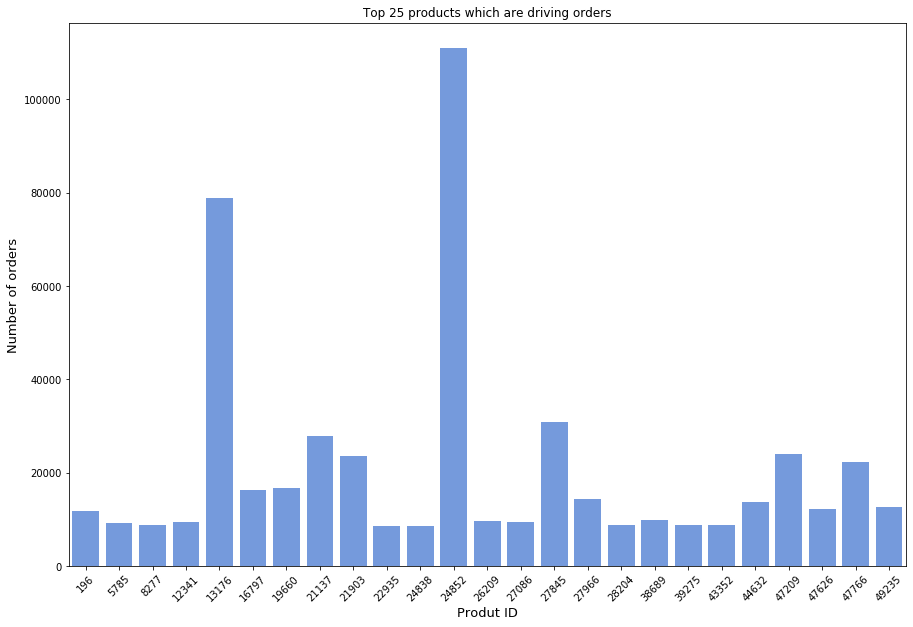

In [28]:
plt.figure(figsize=(15,10))
sns.barplot(x='product_id', y='orders',data=productorderpreference.iloc[:25, :], color='cornflowerblue')
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Produt ID', fontsize=13)
plt.title('Top 25 products which are driving orders')
plt.xticks(rotation = 45);

Let us check what is the order percent for these 25 products

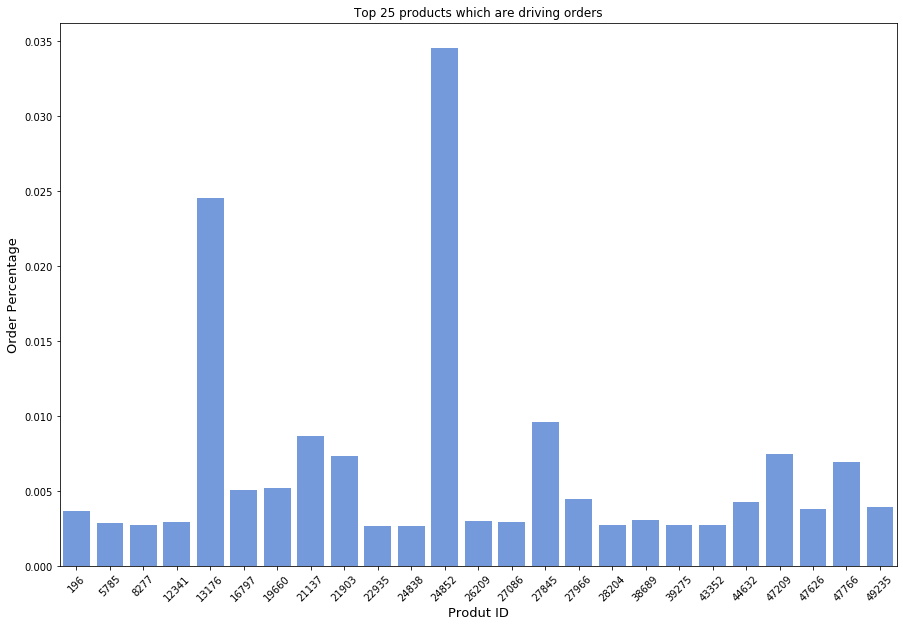

In [29]:
plt.figure(figsize=(15,10))
sns.barplot(x='product_id', y='orderspercent',data=productorderpreference.iloc[:25, :], color='cornflowerblue')
plt.ylabel('Order Percentage', fontsize=13)
plt.xlabel('Produt ID', fontsize=13)
plt.title('Top 25 products which are driving orders');
plt.xticks(rotation = 45);

#### Top 2 products which are driving most of the orders 

The top 2 products which are driving most of the orders are 24852 and 13176. They are present in 3.5% and 2.5% of all the orders. Let us see what department and aisle these products belong to.

In [30]:
Top2drivingproducts = merged_data[(merged_data.product_id == 24852) | (merged_data.product_id == 13176)]
Top2drivingproducts = Top2drivingproducts[['product_id','product_name','aisle','department']].drop_duplicates()
Top2drivingproducts

,product_id,product_name,aisle,department
10597350,13176,Bag of Organic Bananas,fresh fruits,produce
11196487,24852,Banana,fresh fruits,produce


Both the top 2 products are from the 'produce' department and the 'fresh fruits' aisle

We will check how many of the products are being re-ordered across departments and aisles. Let us plot the top 20 departmenst and aisles with highest re-order ratio

#### Departments and their highest re-order percentage 

In [31]:
department_re_order = merged_data.groupby('department').agg({'reordered' : ['mean']}).reset_index()
department_re_order.columns = ['department','re_order_ratio']
department_re_order = department_re_order.sort_values(by='re_order_ratio', ascending=False)

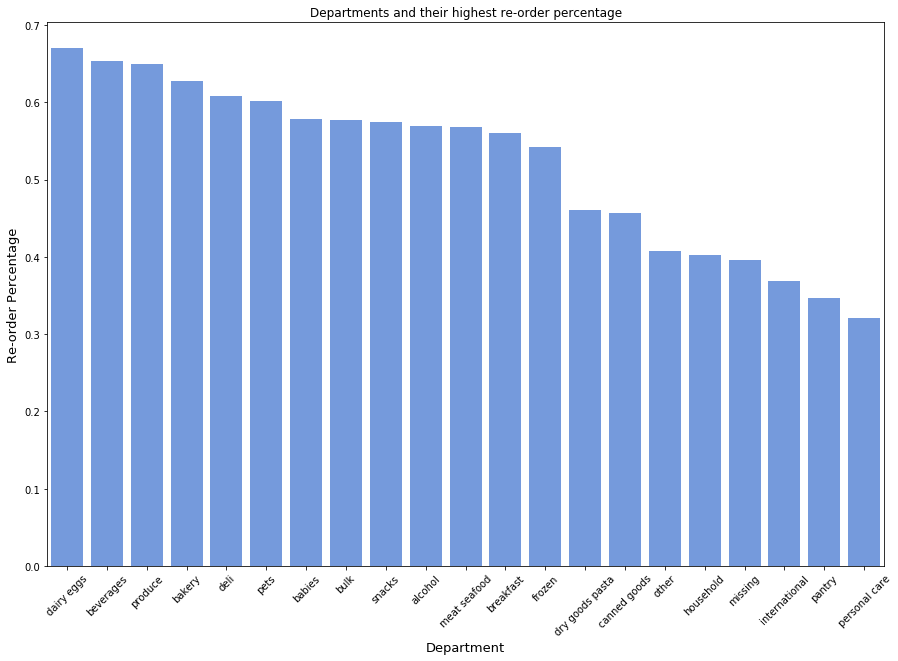

In [32]:
plt.figure(figsize=(15,10))
sns.barplot(x='department', y='re_order_ratio',data=department_re_order, color='cornflowerblue')
plt.ylabel('Re-order Percentage', fontsize=13)
plt.xlabel('Department', fontsize=13)
plt.title('Departments and their highest re-order percentage');
plt.xticks(rotation = 45);

Departments dairy eggs, beverages, and produce are the top 3 departments with highest re-order percentage. International, pantry and personal care are the departments with the lowest re-order percentage.

We will now repeat the same exercise for aisles. As the number of aisles are 134, we will look at the top 20 aisles with highest re-order percentage.

#### Top 20 aisles with highest re-order percentage 

In [33]:
aisle_re_order = merged_data.groupby('aisle').agg({'reordered' : ['mean']}).reset_index()
aisle_re_order.columns = ['aisle','re_order_ratio']
aisle_re_order = aisle_re_order.sort_values(by='re_order_ratio', ascending=False)

In [34]:
aisle_re_order

,aisle,re_order_ratio
83,milk,0.781428
131,water seltzer sparkling water,0.729593
50,fresh fruits,0.718104
41,eggs,0.705366
119,soy lactosefree,0.692551
96,packaged produce,0.690734
133,yogurt,0.686489
33,cream,0.685046
11,bread,0.670168
110,refrigerated,0.663302


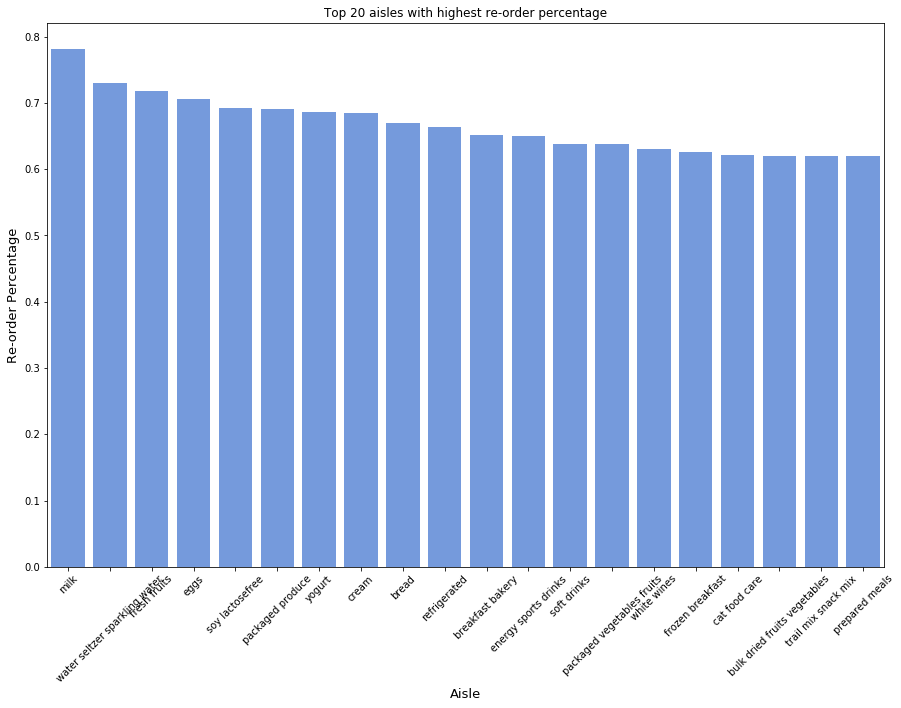

In [35]:
plt.figure(figsize=(15,10))
sns.barplot(x='aisle', y='re_order_ratio',data=aisle_re_order.iloc[:20, :], color='cornflowerblue')
plt.ylabel('Re-order Percentage', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.title('Top 20 aisles with highest re-order percentage');
plt.xticks(rotation = 45);

The top 3 aisles with highest re-order percentage are milk, water seltzer sparkling water, and fresh fruits. The bottom 3 aisles with the lowest re-order percentage are spices seasonings, baking supplies decor, and first - aid.

Let us look at the re-order percentage by both the day of week and hour of the day

#### Reorder percent by day of week and hour of day 

In [36]:
re_order_pattern = merged_data.groupby(['order_dow','order_hour_of_day']).agg({'reordered' : ['mean']}).reset_index()
re_order_pattern.columns = ['order_dow','order_hour_of_day','re_order_percent']
re_order_pattern = re_order_pattern.pivot('order_dow','order_hour_of_day','re_order_percent')

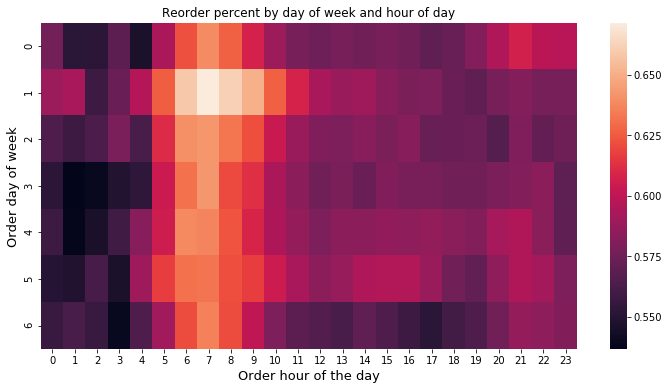

In [37]:
plt.figure(figsize=(12,6))
sns.heatmap(re_order_pattern)
plt.ylabel('Order day of week', fontsize=13)
plt.xlabel('Order hour of the day', fontsize=13)
plt.title("Reorder percent by day of week and hour of day");

Most of the products that are re-ordered occur between 6AM to 9AM thriughout the week. The highest re-order percentage is on day 1 at 7AM.

We can check if the order in which the products are added to the cart influence the re-ordering of the product i.e. we will be checking if the hypothesis of "Sooner the products are added to the cart, higher the re-order percentage" is validated.

#### Relation between Add to cart order and Reorder ratio 

In [38]:
# Max add to cart order in the dataset
merged_data['add_to_cart_order'].max()
merged_data['add_to_cart_order'].quantile(0.999)

49.0

While the maximum number of products added to the cart is 145, we see that the 99.9% of the products have a max add to cart order of 49. So, let us deal with products which have add to cart order of less than equal to 49.

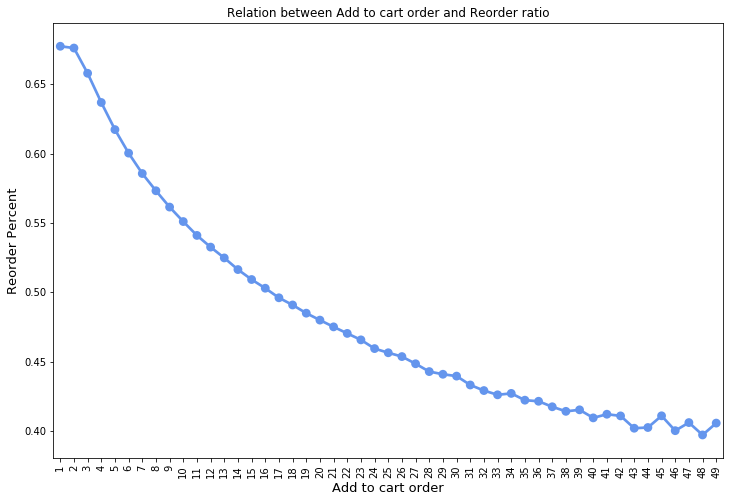

In [39]:
add_to_cart_reorder = merged_data[(merged_data.add_to_cart_order <= 49)]
add_to_cart_reorder = add_to_cart_reorder.groupby(['add_to_cart_order']).agg({'reordered' : ['mean']}).reset_index()
add_to_cart_reorder.columns = ['add_to_cart_order','re_order_percent']
plt.figure(figsize=(12,8))
sns.pointplot(add_to_cart_reorder['add_to_cart_order'].values, add_to_cart_reorder['re_order_percent'].values, alpha=0.8, color='cornflowerblue')
plt.ylabel('Reorder Percent', fontsize=13)
plt.xlabel('Add to cart order', fontsize=13)
plt.title("Relation between Add to cart order and Reorder ratio")
plt.xticks(rotation='vertical')
plt.show()

There is a very strong inverse relation between add to cart order and re-order percent. We can see that as the order in which the product is added to the cart increases, the re-order percent decreases.

#### Count of orders by Department 

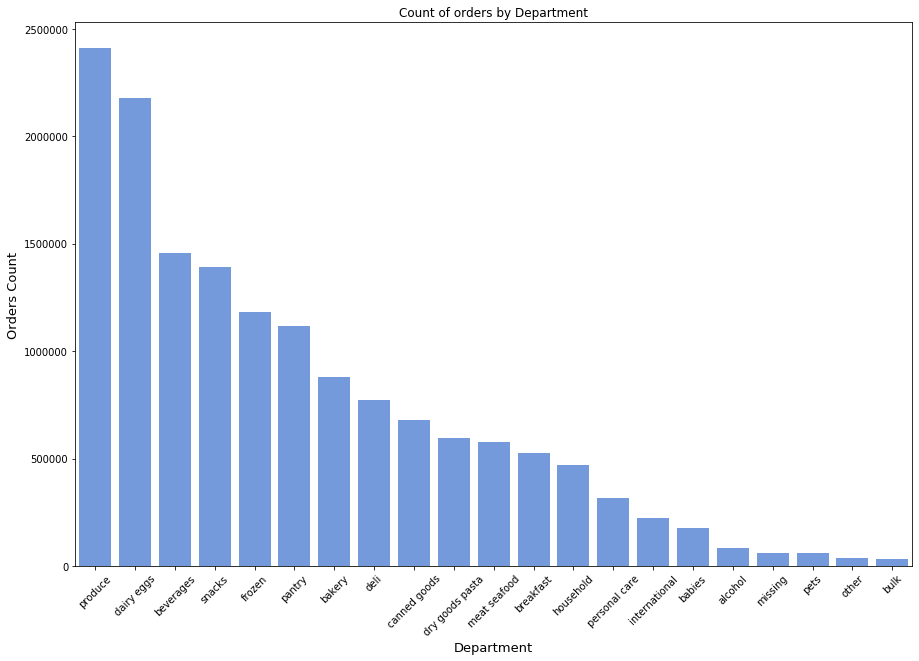

In [44]:
orders_department = merged_data[['order_id', 'department']].drop_duplicates().groupby(by=['department']).agg({'order_id' : ['count']}).reset_index()
orders_department.columns = ['department', 'orders_count']
plt.figure(figsize=(15,10))
sns.barplot(x='department', y='orders_count',data=orders_department.sort_values(by='orders_count', ascending=False), color='cornflowerblue')
plt.ylabel('Orders Count', fontsize=13)
plt.xlabel('Department', fontsize=13)
plt.title('Count of orders by Department');
plt.xticks(rotation = 45);

#### Count of orders by aisles 

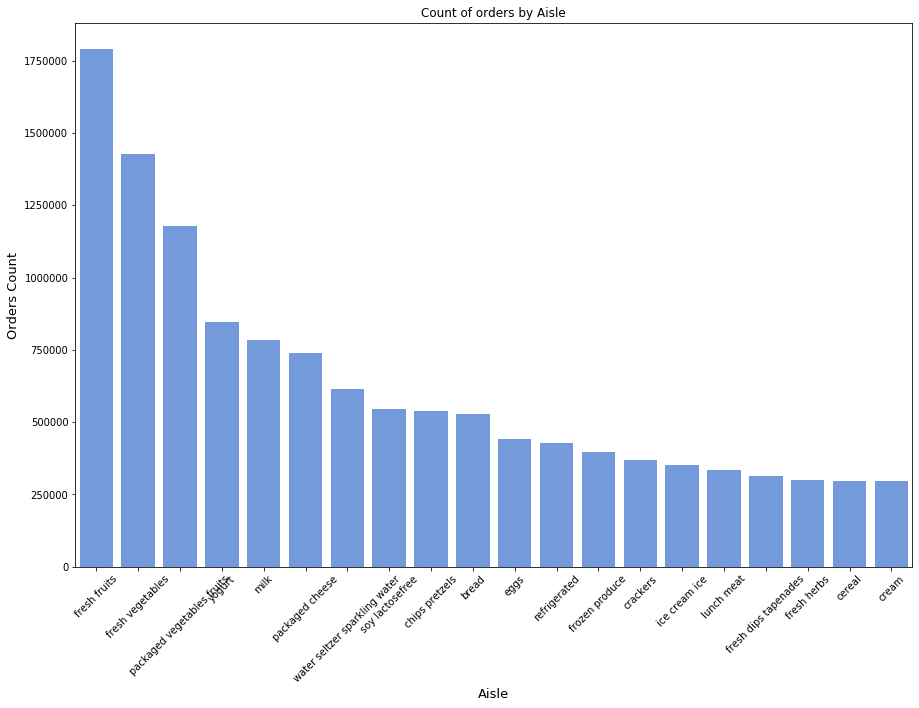

In [47]:
orders_aisle = merged_data[['order_id', 'aisle']].drop_duplicates().groupby(by=['aisle']).agg({'order_id' : ['count']}).reset_index()
orders_aisle.columns = ['aisle', 'orders_count']
plt.figure(figsize=(15,10))
sns.barplot(x='aisle', y='orders_count',data=orders_aisle.sort_values(by='orders_count', ascending=False).iloc[:20, :], color='cornflowerblue')
plt.ylabel('Orders Count', fontsize=13)
plt.xlabel('Aisle', fontsize=13)
plt.title('Count of orders by Aisle');
plt.xticks(rotation = 45);

#### Top Products sold in each Department 

In [65]:
orders_department_product = merged_data[['order_id', 'product_name', 'department']].drop_duplicates().groupby(by=['department', 'product_name']).agg({'order_id' : ['count']}).reset_index()
orders_department_product.columns = ['department', 'product_name','orders_count']
orders_department_product.sort_values(by='orders_count', ascending=False).groupby(by= ['department'], axis=0).head(1)

,department,product_name,orders_count
41849,produce,Banana,472565
13508,dairy eggs,Organic Whole Milk,137905
7318,beverages,Sparkling Water Grapefruit,75886
15528,deli,Original Hummus,71314
2144,bakery,100% Whole Wheat Bread,60816
18167,frozen,Blueberries,55946
26280,meat seafood,Boneless Skinless Chicken Breasts,50281
30237,pantry,Extra Virgin Olive Oil,50255
10250,canned goods,Organic Black Beans,38001
21928,household,100% Recycled Paper Towels,27864


#### Top Products sold in each Aisle 

In [67]:
orders_aisle_product = merged_data[['order_id', 'product_name', 'aisle']].drop_duplicates().groupby(by=['aisle', 'product_name']).agg({'order_id' : ['count']}).reset_index()
orders_aisle_product.columns = ['aisle', 'product_name','orders_count']
orders_aisle_product.sort_values(by='orders_count', ascending=False).groupby(by= ['aisle'], axis=0).head(1).head(10)

,aisle,product_name,orders_count
19407,fresh fruits,Banana,472565
36655,packaged vegetables fruits,Organic Baby Spinach,241921
30905,milk,Organic Whole Milk,137905
20378,fresh vegetables,Organic Yellow Onion,113426
14194,cream,Organic Half & Half,76360
48439,water seltzer sparkling water,Sparkling Water Grapefruit,75886
19277,fresh dips tapenades,Original Hummus,71314
19812,fresh herbs,Organic Cilantro,69524
4136,bread,100% Whole Wheat Bread,60816
35721,packaged cheese,Organic Whole String Cheese,59676


#### Orders containing only pershable orders

- Below, we are trying to evaluate what proportion of the total orders belong to only the perishable category

In [77]:
orders_perish = merged_data[['order_id', 'Perishables']].groupby(by=['order_id']).sum().reset_index()
orders_perish.columns = ['order_id', 'Perishables']
print("Proportion of perishables orders are "+"{:.2%}".format(orders_perish[orders_perish.Perishables==0].shape[0]/orders_perish.shape[0]));

Proportion of perishables orders are 8.51%


#### Users with only pershable orders

- Below, we are trying to evaluate what proportion of the total users are buying only pershable products on Instacart

In [79]:
users_perish = merged_data[['user_id', 'Perishables']].groupby(by=['user_id']).sum().reset_index()
users_perish.columns = ['user_id', 'Perishables']
print("Proportion of Users who buy only perishables products are "+"{:.2%}".format(users_perish[users_perish.Perishables==0].shape[0]/users_perish.shape[0]));

Proportion of Users who buy only perishables products are 1.46%


#### Users with atleast 50% of pershable products on an average order

In [92]:
users_perish_proportion = merged_data[['user_id', 'Perishables']].groupby(by=['user_id']).agg({'Perishables' : ['mean']}).reset_index()
users_perish_proportion.columns = ['user_id', 'Perishables_proportion']
print("Proportion of Users who buy atleast 50% perishables products are "+"{:.2%}".format(users_perish_proportion[users_perish_proportion.Perishables_proportion>0.5].shape[0]/users_perish_proportion.shape[0]));

Proportion of Users who buy atleast 50% perishables products are 57.95%


#### Average re-ordered products in an order 

In [82]:
# percentage of re-orders
print("On an average, the re-ordered products in an order are "+"{:.2%}".format(merged_data.reordered.sum() / merged_data.shape[0]))

On an average, the re-ordered products in an order are 58.97%


#### Average Non re-ordered products in an order

- Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered. Let us check that now.

In [87]:
grouped_df = merged_data.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

1    0.879151
0    0.120849
Name: reordered, dtype: float64

- About 12% of the orders in the data has no re-ordered items